<a href="https://colab.research.google.com/github/drwatson93/Stock-Trend-Price-Prediction-Models/blob/main/Stock_Trend_%26_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font size="6">Stock Trend & Price Prediction Models</font></center></h1>


<center><img src="https://miro.medium.com/max/3840/1*opzxrBna63YDbd8_pM5trw.png" height="300" width="1920"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Data Collection - Read Historical Prices</a>  
- <a href='#4'>Data Preparation - Checking the quality of the data</a>  
    - <a href='#41'>Glimpse the data</a>  
    - <a href='#42'>Check missing data</a>
- <a href='#5'>Data exploration - Decomposition</a>
- <a href='#9'>Feature Generation - Technical Indicators</a>
- <a href='#6'>Predictive models</a>  
    - <a href='#62'>k-Nearest Neighbours</a>     
    - <a href='#63'>Linear Regression</a> 
    - <a href='#64'>XGBoost</a> 
    - <a href='#65'>Prophet</a> 
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>

# <a id="1">Introduction</a>  
In this notebook I will be using a series of predictive models (KNN, Linear Regression, Prophet, XGBoost, ) library to predict future prices of stocks using technical indicator as features. Out of the selected models we will cross validate each and select the best performing. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to articles on Investopedia or the brief description give at the creation of each feature.

To provide linear flow to the notebook we will be using the 7 steps to machine learning deployment.
1. Data Collection.
2. Data Preparation.
3. Choosing a Model.
4. Training the Model.
5. Evaluate the Model.
6. Parameter Tuning.
7. Make Predictions.
---


<left><img src="https://miro.medium.com/max/700/0*V0GyOt3LoDVfY7y5.png" height="100" width="700"></img></left>

In [ ]:
#@title
import os
import numpy as np
import pandas as pd
from datetime import date
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Importing data from Yahoo Finance.
!pip install yfinance
import yfinance as yf

# to make this notebook's output stable across runs
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Facebook Prophet requirements
!pip install pystan==2.19.1.1 
!pip install prophet
from prophet import Prophet

# Change default background color for all visualizations
#layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
#fig = go.Figure(layout=layout)
#templated_fig = pio.to_templated(fig)
#pio.templates['my_template'] = templated_fig.layout.template
#pio.templates.default = 'my_template'

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=16b08b74d86527a76daf7e55b9c87c9f8423493154092c14340fe758a33c3078
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 178 kB 19.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641634 sha256=831001d2bc97a730774171d78beb5c96ff8f48602ed2d39d1a44208b383d0536
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


# <a id="2">Data Collection - Read Historical Prices</a>  
I read historical data frame for a chosen stock (e.g. AAPL) which I am going to analyze. The New York Stock Exchange dataset gathered from Yahoo Finance provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [ ]:
# loading data from Yahoo Finance.
TICKER = 'AAPL'
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

def load_data(TICKER, START, TODAY):
    data = yf.download(TICKER, START, TODAY)
    data.reset_index(inplace=True)
    return data

selected_stock_data = load_data(TICKER, START, TODAY)

[*********************100%***********************]  1 of 1 completed


In [ ]:
selected_stock_data.head()

Date      Open      High       Low     Close  Adj Close     Volume
0 2010-01-04  7.622500  7.660714  7.585000  7.643214   6.572422  493729600
1 2010-01-05  7.664286  7.699643  7.616071  7.656429   6.583784  601904800
2 2010-01-06  7.656429  7.686786  7.526786  7.534643   6.479061  552160000
3 2010-01-07  7.562500  7.571429  7.466071  7.520714   6.467082  477131200
4 2010-01-08  7.510714  7.571429  7.466429  7.570714   6.510078  447610800

# <a id="3">Data Preparation - Checking the quality of the data.</a>  

## <a id="41">Glimpse the data</a>

I start by drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below the OHLC chart I draw Volume chart which shows number of stocks traded each day.

An OHLC chart shows the open, high, low and close prices of a stock. It shows you how the price was changing during a particular day and give you a sense of e.g. momentum or volatility of stock. The tip of the lines represent the low and high values and the horizontal segments represent the open and close values. Sample points where the close value is higher (lower) then the open value are called increasing (decreasing). By default, increasing items are drawn in green whereas decreasing are drawn in red.



In [ ]:
#@title
#plot raw data
fig = make_subplots(rows=2, 
                    cols=1,
                    subplot_titles=('{} - Open and Close Price'.format(TICKER), '{} - Volume'.format(TICKER)),             
                    )

fig.add_trace(go.Ohlc(x=selected_stock_data.Date,
                      open=selected_stock_data.Open,
                      high=selected_stock_data.High,
                      low=selected_stock_data.Low,
                      close=selected_stock_data.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Volume, name='Volume'), row=2, col=1)

#fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(
    title='{}'.format(TICKER),
    yaxis_title='{} Stock'.format(TICKER),
    xaxis_title='Year',
    xaxis_rangeslider_visible=False,
    height=900,
    width =1500,
)

fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)

fig.show()

## <a id="42">Check missing data</a>  

Checking the type of data and if we have any nulls.

In [ ]:
# Checking the type of data and if we have any nulls.
selected_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895 entries, 0 to 2894
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2895 non-null   datetime64[ns]
 1   Open       2895 non-null   float64       
 2   High       2895 non-null   float64       
 3   Low        2895 non-null   float64       
 4   Close      2895 non-null   float64       
 5   Adj Close  2895 non-null   float64       
 6   Volume     2895 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 158.4 KB


## <a id="5">Data exploration - Decomposition</a>  


<h3>Time Series Components</h3>
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

* **Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled.
* **Non-Systematic**: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

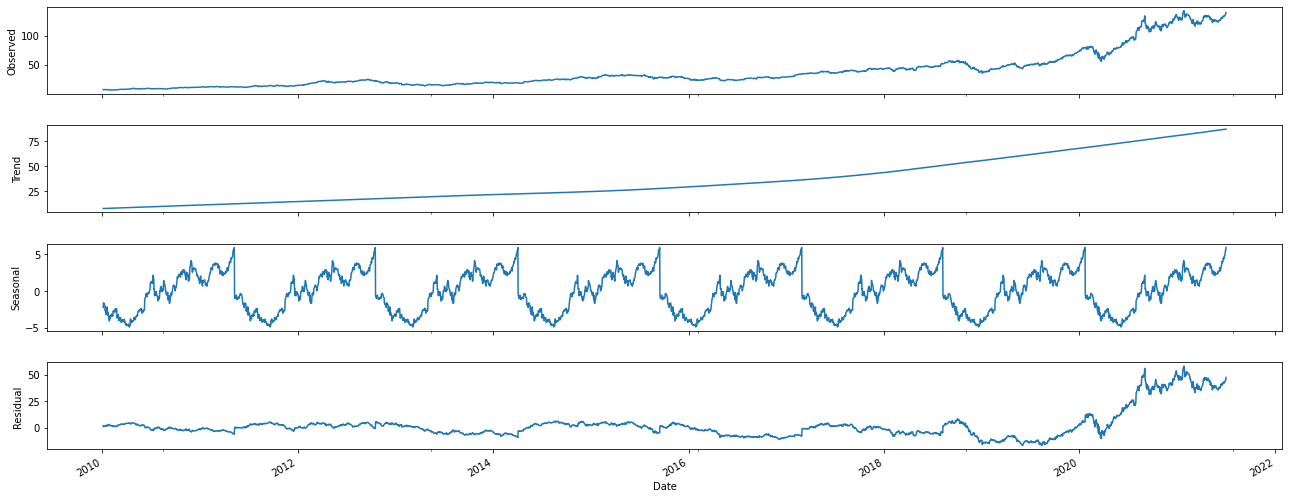

In [ ]:
#@title
selected_stock_data_close = selected_stock_data[['Date', 'Close']].copy()
selected_stock_data_close = selected_stock_data_close.set_index('Date')
selected_stock_data_close.head()

decomp = decompose(selected_stock_data_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)


## <a id="9">Feature Generation - Technical Indicators</a>  

**Moving Averages**

Moving Averages (MA) help to smooth out stock prices on a chart by filtering out short-term price fluctuations. We calculate moving averages over a defined period of time e.g. last 9, 50 or 200 days. There are two (most common) averages used in technical analysis which are:

* Simple Moving Average (SMA) - a simple average calculated over last N days e.g. 50, 100 or 200,
* Exponential Moving Average (EMA) - an average where greater weights are applied to recent prices.

MAs and their crossovers (see Golden Cross and Death Cross are often used as trade signals as they are so simple yet powerful.

I'm calculating few moving averages to be used as features:  **SMA5** ,  **SMA10** ,  **SMA15** ,  **SMA30**  and  **EMA9** .

In [ ]:
#@title
selected_stock_data['EMA_9'] = selected_stock_data['Close'].ewm(9).mean().shift()
selected_stock_data['SMA_5'] = selected_stock_data['Close'].rolling(5).mean().shift()
selected_stock_data['SMA_10'] = selected_stock_data['Close'].rolling(10).mean().shift()
selected_stock_data['SMA_15'] = selected_stock_data['Close'].rolling(15).mean().shift()
selected_stock_data['SMA_30'] = selected_stock_data['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close, name='Close', opacity=0.2))
fig.show()

In [ ]:
selected_stock_data

Date        Open        High  ...      SMA_10      SMA_15      SMA_30
0    2010-01-04    7.622500    7.660714  ...         NaN         NaN         NaN
1    2010-01-05    7.664286    7.699643  ...         NaN         NaN         NaN
2    2010-01-06    7.656429    7.686786  ...         NaN         NaN         NaN
3    2010-01-07    7.562500    7.571429  ...         NaN         NaN         NaN
4    2010-01-08    7.510714    7.571429  ...         NaN         NaN         NaN
...         ...         ...         ...  ...         ...         ...         ...
2890 2021-06-28  133.410004  135.250000  ...  131.901999  130.149999  127.925332
2891 2021-06-29  134.800003  136.490005  ...  132.331999  130.741999  128.169666
2892 2021-06-30  136.169998  137.410004  ...  133.000999  131.381332  128.504999
2893 2021-07-01  136.600006  137.330002  ...  133.682001  132.036666  128.908666
2894 2021-07-02  137.899994  140.000000  ...  134.230002  132.780667  129.328000

[2895 rows x 12 columns]

**Relative Strength Index**

Another commonly used indicator is a Relative Strength Index (RSI) that indicates magnitude of recent price changes. It can show that a stock is either overbought or oversold. Typically RSI value of 70 and above signal that a stock is becoming overbought/overvalued, meanwhile value of 30 and less can mean that it is oversold. Full range of RSI is from 0 to 100.

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [ ]:
#@title
def relative_strength_idx(selected_stock_data, n=14):
    close = selected_stock_data['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

selected_stock_data['RSI'] = relative_strength_idx(selected_stock_data).fillna(0)

fig = go.Figure(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.RSI, name='RSI'))

fig.show()

In [ ]:
selected_stock_data

Date        Open        High  ...      SMA_15      SMA_30        RSI
0    2010-01-04    7.622500    7.660714  ...         NaN         NaN        NaN
1    2010-01-05    7.664286    7.699643  ...         NaN         NaN   0.000000
2    2010-01-06    7.656429    7.686786  ...         NaN         NaN   0.000000
3    2010-01-07    7.562500    7.571429  ...         NaN         NaN   0.000000
4    2010-01-08    7.510714    7.571429  ...         NaN         NaN   0.000000
...         ...         ...         ...  ...         ...         ...        ...
2890 2021-06-28  133.410004  135.250000  ...  130.149999  127.925332  74.876317
2891 2021-06-29  134.800003  136.490005  ...  130.741999  128.169666  76.558975
2892 2021-06-30  136.169998  137.410004  ...  131.381332  128.504999  82.043799
2893 2021-07-01  136.600006  137.330002  ...  132.036666  128.908666  81.000092
2894 2021-07-02  137.899994  140.000000  ...  132.780667  129.328000  80.462825

[2895 rows x 13 columns]

**MACD**

Moving Average Convergence Divergence (MACD) is an indicator which shows the relationship between two exponential moving averages i.e. 12-day and 26-day EMAs. We obtain MACD by substracting 26-day EMA (also called slow EMA) from the 12-day EMA (or fast EMA).

In [ ]:
#@title
EMA_12 = pd.Series(selected_stock_data['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(selected_stock_data['Close'].ewm(span=26, min_periods=26).mean())
selected_stock_data['MACD'] = pd.Series(EMA_12 - EMA_26)
selected_stock_data['MACD_signal'] = pd.Series(selected_stock_data.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [ ]:
selected_stock_data

Date        Open        High  ...        RSI      MACD  MACD_signal
0    2010-01-04    7.622500    7.660714  ...        NaN       NaN          NaN
1    2010-01-05    7.664286    7.699643  ...   0.000000       NaN          NaN
2    2010-01-06    7.656429    7.686786  ...   0.000000       NaN          NaN
3    2010-01-07    7.562500    7.571429  ...   0.000000       NaN          NaN
4    2010-01-08    7.510714    7.571429  ...   0.000000       NaN          NaN
...         ...         ...         ...  ...        ...       ...          ...
2890 2021-06-28  133.410004  135.250000  ...  74.876317  1.845963     1.206551
2891 2021-06-29  134.800003  136.490005  ...  76.558975  2.067162     1.378673
2892 2021-06-30  136.169998  137.410004  ...  82.043799  2.267165     1.556372
2893 2021-07-01  136.600006  137.330002  ...  81.000092  2.422755     1.729648
2894 2021-07-02  137.899994  140.000000  ...  80.462825  2.731634     1.930045

[2895 rows x 15 columns]

**Shift label column**

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [ ]:
selected_stock_data['Close'] = selected_stock_data['Close'].shift(-1)

In [ ]:
selected_stock_data

Date        Open        High  ...        RSI      MACD  MACD_signal
0    2010-01-04    7.622500    7.660714  ...        NaN       NaN          NaN
1    2010-01-05    7.664286    7.699643  ...   0.000000       NaN          NaN
2    2010-01-06    7.656429    7.686786  ...   0.000000       NaN          NaN
3    2010-01-07    7.562500    7.571429  ...   0.000000       NaN          NaN
4    2010-01-08    7.510714    7.571429  ...   0.000000       NaN          NaN
...         ...         ...         ...  ...        ...       ...          ...
2890 2021-06-28  133.410004  135.250000  ...  74.876317  1.845963     1.206551
2891 2021-06-29  134.800003  136.490005  ...  76.558975  2.067162     1.378673
2892 2021-06-30  136.169998  137.410004  ...  82.043799  2.267165     1.556372
2893 2021-07-01  136.600006  137.330002  ...  81.000092  2.422755     1.729648
2894 2021-07-02  137.899994  140.000000  ...  80.462825  2.731634     1.930045

[2895 rows x 15 columns]

**Drop invalid samples**

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [ ]:
selected_stock_data = selected_stock_data.iloc[33:] # Because of moving averages and MACD line
selected_stock_data = selected_stock_data[:-1]      # Because of shifting close price

selected_stock_data.index = range(len(selected_stock_data))

In [ ]:
selected_stock_data

Date        Open        High  ...        RSI      MACD  MACD_signal
0    2010-02-22    7.226429    7.232143  ...  59.006024 -0.020182    -0.043646
1    2010-02-23    7.142857    7.190357  ...  51.774102 -0.027162    -0.039953
2    2010-02-24    7.079643    7.194286  ...  52.099884 -0.022640    -0.036165
3    2010-02-25    7.049286    7.245000  ...  67.635582 -0.015228    -0.031669
4    2010-02-26    7.227857    7.327500  ...  66.703153 -0.002156    -0.025423
...         ...         ...         ...  ...        ...       ...          ...
2856 2021-06-25  133.460007  133.889999  ...  73.516058  1.694601     1.046698
2857 2021-06-28  133.410004  135.250000  ...  74.876317  1.845963     1.206551
2858 2021-06-29  134.800003  136.490005  ...  76.558975  2.067162     1.378673
2859 2021-06-30  136.169998  137.410004  ...  82.043799  2.267165     1.556372
2860 2021-07-01  136.600006  137.330002  ...  81.000092  2.422755     1.729648

[2861 rows x 15 columns]

## <a id="6">Predictive model - Choosing the right model</a>  

We now need to split our data for training and testing. As well as create the number of K-folds we would like to use for additional training.

In [ ]:
#@title
from sklearn.model_selection import KFold
n_split = 10

kf = KFold(n_splits=n_split,shuffle=False)

In [ ]:
#@title
#drop_cols = ['Date']
drop_cols = ['Volume', 'Open', 'Low', 'High', 'Adj Close']

selected_stock_data_final = selected_stock_data.drop(drop_cols, axis=1)
selected_stock_data_final.set_index('Date', inplace=True)

X_stock_train_close, X_stock_test_close, y_stock_train, y_stock_test  = train_test_split(selected_stock_data_final, selected_stock_data_final['Close'], test_size=0.10, random_state=RANDOM_STATE, shuffle=False)


In [ ]:
#@title
X_stock_train = X_stock_train_close.drop('Close', axis=1)
X_stock_test = X_stock_test_close.drop('Close', axis=1)

In [ ]:
X_stock_train

EMA_9      SMA_5     SMA_10  ...        RSI      MACD  MACD_signal
Date                                         ...                                  
2010-02-22   7.158434   7.220929   7.108893  ...  59.006024 -0.020182    -0.043646
2010-02-23   7.158374   7.221214   7.126607  ...  51.774102 -0.027162    -0.039953
2010-02-24   7.146013   7.175929   7.137107  ...  52.099884 -0.022640    -0.036165
2010-02-25   7.148102   7.162429   7.153071  ...  67.635582 -0.015228    -0.031669
2010-02-26   7.154857   7.155786   7.177643  ...  66.703153 -0.002156    -0.025423
...               ...        ...        ...  ...        ...       ...          ...
2020-05-06  70.300943  73.066000  71.429250  ...  59.767372  1.912986     1.364175
2020-05-07  70.786599  73.711000  72.042500  ...  64.834229  2.085830     1.508506
2020-05-08  71.301439  74.208000  72.760250  ...  73.347395  2.324916     1.671788
2020-05-11  71.924545  75.261000  73.439250  ...  84.589131  2.583061     1.854042
2020-05-12  72.607341  76.353500  74.235250  ...  77.895383  2.684079     2.020050

[2574 rows x 8 columns]

In [ ]:
X_stock_test

EMA_9       SMA_5  ...      MACD  MACD_signal
Date                                ...                       
2020-05-13   73.131857   77.046001  ...  2.657651     2.147570
2020-05-14   73.509921   77.397000  ...  2.644352     2.246927
2020-05-15   73.897429   77.687001  ...  2.567301     2.311001
2020-05-18   74.200436   77.566000  ...  2.622263     2.373254
2020-05-19   74.654392   77.563499  ...  2.599145     2.418432
...                ...         ...  ...       ...          ...
2021-06-25  129.904661  132.770001  ...  1.694601     1.046698
2021-06-28  130.225195  133.300000  ...  1.845963     1.206551
2021-06-29  130.680675  133.795999  ...  2.067162     1.378673
2021-06-30  131.245608  134.266000  ...  2.267165     1.556372
2021-07-01  131.817048  134.918002  ...  2.422755     1.729648

[287 rows x 8 columns]

In [ ]:
#@title
test_size  = 0.10
#valid_size = 0.30

test_split_idx  = int(selected_stock_data.shape[0] * (1-test_size))
#valid_split_idx = int(selected_stock_data.shape[0] * (1-(valid_size+test_size)))

train_df  = selected_stock_data.loc[:test_split_idx].copy()
#valid_df  = selected_stock_data.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = selected_stock_data.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
#fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

# <a id="64">Model - XGBoost</a>  

In [ ]:
#@title
%%time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

parameters = {
    'n_estimators': [250],
    'learning_rate': [0.5],
    'max_depth': [15],
    'gamma': [0.05],
}

eval_set = [(X_stock_train, y_stock_train), (X_stock_test, y_stock_test)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(estimator = model, 
                   param_grid = parameters, 
                   cv=5,
                   verbose = 1,
                   n_jobs = -1,
                   scoring = 'neg_root_mean_squared_error'
                   )

clf.fit(X_stock_train, y_stock_train)

print('Best params: {}'.format(clf.best_params_))
print('Best validation score = {}'.format(clf.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Best params: {'gamma': 0.05, 'learning_rate': 0.5, 'max_depth': 15, 'n_estimators': 250}
Best validation score = -4.979040451854887
CPU times: user 2.03 s, sys: 87.8 ms, total: 2.12 s
Wall time: 10.7 s


In [ ]:
#@title
model = xgb.XGBRegressor(**clf.best_params_)
model.fit(X_stock_train, y_stock_train, verbose=True)

[18:10:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
#@title
xboost_pred = model.predict(X_stock_test)
print('XGBoostRegressor_y_true = {}'.format(np.array(y_stock_test)[:5]))
print('XGBoostRegressor_y_pred = {}'.format(xboost_pred[:5]))

XGBoostRegressor_y_true = [77.38500214 76.92749786 78.73999786 78.28500366 79.80750275]
XGBoostRegressor_y_pred = [78.36503 78.72414 79.44346 78.73104 79.6452 ]


In [ ]:
#@title
print('XGBoostRegressor mean_squared_error = {}'.format(mean_squared_error(y_stock_test, xboost_pred)))

XGBoostRegressor mean_squared_error = 2343.34817232623


In [ ]:
#@title
predicted_prices = selected_stock_data.loc[test_split_idx:].copy()
predicted_prices['Close'] = xboost_pred

fig = make_subplots(rows=2, 
                    cols=1, 
                    subplot_titles=('{} - Truth and Prediction Value - XGBoost'.format(TICKER), '{} - Closer look'.format(TICKER)))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=xboost_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [ ]:
#@title
for train_index, test_index in kf.split(selected_stock_data_final):

  X_train = selected_stock_data_final.iloc[train_index]
  X_test = selected_stock_data_final.iloc[test_index]
  y_train, y_test = selected_stock_data_final['Close'][train_index], selected_stock_data_final['Close'][test_index]

  X_train = X_train.drop('Close', axis=1)
  X_test = X_test.drop('Close', axis=1)
  
  model = xgb.XGBRegressor(**clf.best_params_)
  model.fit(X_train, y_train)
  xboost_pred = model.predict(X_test)

  predicted_prices = X_test.copy()
  predicted_prices['Close'] = xboost_pred

  fig = make_subplots(rows=2, 
                      cols=1,
                      subplot_titles=('{} - Truth and Prediction Value - XGBoost'.format(TICKER), '{} - Closer look'.format(TICKER))
                      )
  fig.add_trace(go.Scatter(x=selected_stock_data_final.index, y=selected_stock_data_final.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)
  
  fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)
  fig.update_layout(
      height=900,
      width=1400
      )
  
  fig.show()

[18:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[18:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# <a id="64">Model - Linear Regression</a>

Now lets train and test on a linear regression model.

In [ ]:
#@title
from sklearn.linear_model import LinearRegression

lg_model = LinearRegression()
lg_model.fit(X_stock_train,y_stock_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#@title
lin_reg_pred = lg_model.predict(X_stock_test)
print('y_true = {}'.format(np.array(y_stock_test)[:5]))
print('y_pred = {}'.format(lin_reg_pred[:5]))

y_true = [77.38500214 76.92749786 78.73999786 78.28500366 79.80750275]
y_pred = [77.47706087 77.27517211 76.92356312 78.03296906 78.64862601]


In [ ]:
#@title
print('Linear Regression mean_squared_error = {}'.format(mean_squared_error(y_stock_test, lin_reg_pred)))

Linear Regression mean_squared_error = 6.823561239956028


In [ ]:
#@title
predicted_prices = selected_stock_data.loc[test_split_idx:].copy()
predicted_prices['Close'] = lin_reg_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=lin_reg_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)
fig.update_layout(title='Linear Regression Model')
fig.show()

In [ ]:
#@title
for train_index, test_index in kf.split(selected_stock_data_final):

  X_train = selected_stock_data_final.iloc[train_index]
  X_test = selected_stock_data_final.iloc[test_index]
  y_train, y_test = selected_stock_data_final['Close'][train_index], selected_stock_data_final['Close'][test_index]

  X_train = X_train.drop('Close', axis=1)
  X_test = X_test.drop('Close', axis=1)

  lg_model = lg_model = LinearRegression()
  lg_model.fit(X_train, y_train)
  lg_model_pred = lg_model.predict(X_test)

  predicted_prices = X_test.copy()
  predicted_prices['Close'] = lg_model_pred

  fig = make_subplots(rows=2, 
                      cols=1,
                      subplot_titles=('{} - Truth and Prediction Value - Linear Regression'.format(TICKER), '{} - Closer look'.format(TICKER))
                      )
  fig.add_trace(go.Scatter(x=selected_stock_data_final.index, y=selected_stock_data_final.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)
  
  fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)
  fig.update_layout(
      height=900,
      width=1400
      )
  
  fig.show()

# <a id="64">Model - k-Nearest Neighbor</a>

Now lets train and test on a k-Nearest Neighbor model.

In [ ]:
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
#@title
parameters = {
    'n_neighbors': [5, 10, 15, 30, 50],
    'weights': ['uniform','distance']
}

knn = neighbors.KNeighborsRegressor()
clf = GridSearchCV(knn, 
                     parameters, 
                     cv=5, 
                     n_jobs=-1, 
                     scoring = 'neg_root_mean_squared_error')

clf.fit(X_stock_train,y_stock_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15, 30, 50],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [ ]:
#@title
model = neighbors.KNeighborsRegressor(**clf.best_params_)
model.fit(X_stock_train, y_stock_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')

In [ ]:
#@title
knn_pred = model.predict(X_stock_test)
print('y_true = {}'.format(np.array(y_stock_test)[:5]))
print('y_pred = {}'.format(knn_pred[:5]))

y_true = [77.38500214 76.92749786 78.73999786 78.28500366 79.80750275]
y_pred = [78.58046707 79.44377766 80.11158594 79.06945696 79.24525481]


In [ ]:
#@title
# Get the results
print('Linear Regression mean_squared_error = {}'.format(mean_squared_error(y_stock_test, knn_pred)))
print('Best score: {}'.format(clf.best_score_))
print('Best estimator: {}'.format(clf.best_estimator_))
print('Best params: {}'.format(clf.best_params_))

Linear Regression mean_squared_error = 1824.360990766825
Best score: -4.811040735281126
Best estimator: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')
Best params: {'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
#@title
predicted_prices = selected_stock_data.loc[test_split_idx:].copy()
predicted_prices['Close'] = knn_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=knn_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [ ]:
#@title
#kf.split(X_stock_train, y_stock_train)
for train_index, test_index in kf.split(selected_stock_data_final):

  X_train = selected_stock_data_final.iloc[train_index]
  X_test = selected_stock_data_final.iloc[test_index]
  y_train, y_test = selected_stock_data_final['Close'][train_index], selected_stock_data_final['Close'][test_index]

  X_train = X_train.drop('Close', axis=1)
  X_test = X_test.drop('Close', axis=1)

  model = neighbors.KNeighborsRegressor(**clf.best_params_)
  model.fit(X_train, y_train)
  knn_pred = model.predict(X_test)

  predicted_prices = X_test.copy()
  predicted_prices['Close'] = knn_pred

  fig = make_subplots(rows=2, 
                      cols=1,
                      subplot_titles=('{} - Truth and Prediction Value - k-Nearest Neighbor'.format(TICKER), '{} - Closer look'.format(TICKER))
                      )
  fig.add_trace(go.Scatter(x=selected_stock_data_final.index, y=selected_stock_data_final.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)
  
  fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)
  fig.update_layout(
      height=900,
      width=1400
      )
  
  fig.show()


# <a id="65">Model - Prophet</a>

In [ ]:
#@title
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.5],
    'seasonality_prior_scale': [1.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model_P = Prophet(**params).fit(pd.DataFrame({'ds': X_stock_train.index, 'y':y_stock_train}))  # Fit model with given params
    df_cv = cross_validation(model_P,horizon='30 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 223 forecasts with cutoffs between 2011-03-01 00:00:00 and 2020-04-12 00:00:00



   changepoint_prior_scale  seasonality_prior_scale      rmse
0                      0.5                      1.0  4.739627


In [ ]:
#@title
# Creating the Prophet Model
model_P = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=1.0, daily_seasonality=True)

# fitting the model
model_P.fit(pd.DataFrame({'ds': X_stock_train_close.index, 'y':y_stock_train}))

close_prices = model_P.make_future_dataframe(periods=len(X_stock_test.index))

# predicting result on test dates
prophet_pred = model_P.predict(close_prices)

In [ ]:
prophet_pred

ds      trend  ...  multiplicative_terms_upper       yhat
0    2010-02-22   7.238464  ...                         0.0   8.746918
1    2010-02-23   7.247055  ...                         0.0   8.806452
2    2010-02-24   7.255647  ...                         0.0   8.630635
3    2010-02-25   7.264238  ...                         0.0   8.591172
4    2010-02-26   7.272830  ...                         0.0   8.556509
...         ...        ...  ...                         ...        ...
2856 2021-02-19  77.529087  ...                         0.0  79.104810
2857 2021-02-20  77.565103  ...                         0.0  78.958402
2858 2021-02-21  77.601120  ...                         0.0  78.963499
2859 2021-02-22  77.637136  ...                         0.0  79.135318
2860 2021-02-23  77.673152  ...                         0.0  79.220604

[2861 rows x 22 columns]

In [ ]:
#@title
predicted_prices = selected_stock_data.loc[test_split_idx:].copy()
predicted_prices['Close'] = prophet_pred.yhat

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=prophet_pred.yhat,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

# K-Fold Training visualization and Conclusion

Each model performed well when predicting data that showed very little volitility. Once volitility from the year 2020 was presented the model struggled to predict accuracly with the exception of linear regression. I found that Prophet was not able to accuratly predict the next days close price but instead was able to predict a seasonal trend.

Below are the K-fold training for 3 out of the 4 models selected.

* Xgboost
<center><img src="https://raw.githubusercontent.com/drwatson93/Stock-Trend-Price-Prediction-Models/main/XGboost_fix.gif" height="400" width="1600"></img></center>

* Linear Regression
<center><img src="https://raw.githubusercontent.com/drwatson93/Stock-Trend-Price-Prediction-Models/main/Linear-Regression_fix.gif" height="400" width="1920"></img></center>
* KNN - 
<center><img src="https://raw.githubusercontent.com/drwatson93/Stock-Trend-Price-Prediction-Models/main/KNN_fix.gif" height="400" width="1920"></img></center>

* Prophet - good for predicting overal trend and forcasting

Now, can we forcast a years worth of data?

In [ ]:
model_P = Prophet(changepoint_prior_scale=0.50, seasonality_prior_scale=10.0, daily_seasonality=True)

# fitting the model
model_P.fit(pd.DataFrame({'ds': selected_stock_data.Date, 'y':selected_stock_data.Close}))

# making Dataframe of 365 days
future = model_P.make_future_dataframe(periods=365)

# predict
forecast = model_P.predict(future)

In [ ]:
#@title
from fbprophet.plot import plot_plotly
plot_plotly(model_P, forecast)

Can we turn this into an app?

In [ ]:
!pip install -q streamlit

     |████████████████████████████████| 8.0 MB 5.3 MB/s 
     |████████████████████████████████| 75 kB 2.0 MB/s 
     |████████████████████████████████| 111 kB 56.1 MB/s 
     |████████████████████████████████| 4.2 MB 29.7 MB/s 
     |████████████████████████████████| 170 kB 46.3 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 122 kB 47.4 MB/s 
     |████████████████████████████████| 786 kB 17.7 MB/s 
     |████████████████████████████████| 368 kB 34.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.19 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.2.0 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.26.0 which is incompatibl

In [ ]:
!wget https://raw.githubusercontent.com/drwatson93/Stock-Price-Predictor/main/main.py

--2021-08-17 16:32:31--  https://raw.githubusercontent.com/drwatson93/Stock-Price-Predictor/main/main.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1603 (1.6K) [text/plain]
Saving to: ‘main.py’

main.py             100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-08-17 16:32:31 (34.7 MB/s) - ‘main.py’ saved [1603/1603]



In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-08-17 16:32:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.234.77.173, 54.209.131.108, 34.239.30.50, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.234.77.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  39.9MB/s    in 0.3s    

2021-08-17 16:32:33 (39.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: http://a0784fcdab0e.ngrok.io


In [ ]:
!streamlit run /content/main.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.122.134.90:8501

2021-08-17 16:35:00.828 NumExpr defaulting to 2 threads.
[*********************100%***********************]  1 of 1 completed
2021-08-17 16:35:03.205 Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Initial log joint probability = -54.7143
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4697.24   0.000688872       444.903           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4738.02    0.00361583       411.683      0.6889      0.6889      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4753.35    0.00726654       480.791           1           1      352   
    Iter      log prob        ||dx||      ||gra